In [1]:
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from theano import tensor as tt
import matplotlib.pyplot as plt

from data.get_results import get_results
from likelihood import get_kernel
from acquisitions import phase_ucb_acq, generate, likelihood

 E:\Program_Files\Anaconda\envs\testpymc3\lib\site-packages\h5py\__init__.py:36: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
def plot_explore(trace, trials, midpoint=None):
    varnames = [v for v in trace.varnames if '__' not in v]
    var = np.array([trace.get_values(v)for v in varnames]).T[0][200:]
    df = pd.DataFrame(var, columns=varnames)
    
    if midpoint:
        df['x_midpoint'] = midpoint
    explore = (1 - 1. / (1 + df['yscale'][:,None] * np.exp(-df['steepness'][:,None] * (trials - df['x_midpoint'][:,None]))))
    mean = a.mean(axis=0)
    std = a.std(axis=0)
    plt.plot(mean);
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=.1);

In [3]:
def get_params(trace):
    varnames = [v for v in trace.varnames if '__' not in v]
    var = np.array([trace.get_values(v)for v in varnames]).T[0][200:]
    df = pd.DataFrame(var, columns=varnames)
    return df

In [4]:
results = get_results('data/results.json').iloc[3:]
function_names = results['function_name'].unique()
kernel_dict = {f: get_kernel(results, GPy.kern.RBF(1), f) for f in function_names}
functions_dict = results[['function_name', 'function']].drop_duplicates(subset = ['function_name']).set_index('function_name').to_dict()['function']
normalized_functions_dict = {f: np.array(functions_dict[f]) / np.std(functions_dict[f]) for f in function_names}

## Simulate actions with negative quadratic reward

In [5]:
neg_quad = normalized_functions_dict['neg_quad']
neg_quad_kern = kernel_dict['neg_quad']
fmax = np.argmax(neg_quad)

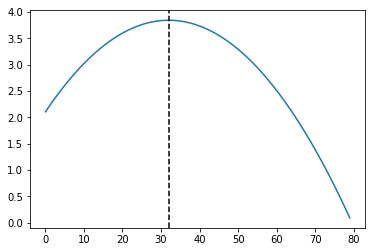

In [6]:
plt.plot(neg_quad);
plt.axvline(x=fmax, ls='--', c='black');

## Strategies

In [7]:
steepness_params = np.array([0, 100, 0, 100, .5])
x_midpoint_params = np.array([10, 20, 10, 10, 10])
yscale_params = np.array([0, 1, 1, 1, 1])
temp_params = [.00001, .0001, .001, .01]
trials = np.arange(20)
titles = ['Pure Exploit', 'Pure Explore', 'Balanced', 'Hard Phase', 'Soft Phase']

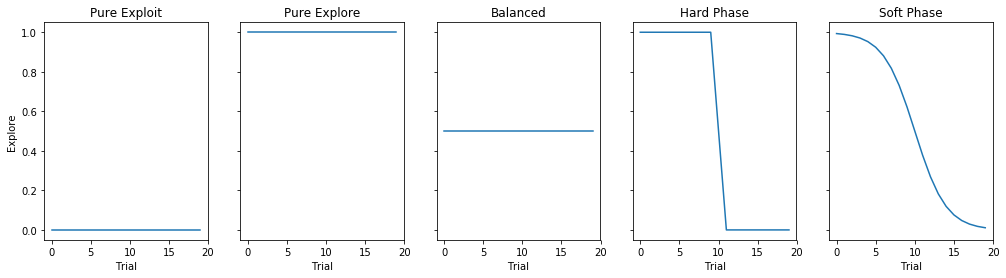

In [8]:
explore = (1 - 1. / (1 + yscale_params[:,None] * np.exp(-steepness_params[:,None] * (trials - x_midpoint_params[:,None]))))
fig, axes = plt.subplots(1, len(steepness_params), sharex=True, sharey=True, figsize=(17, 4))
for i in range(len(axes)):
    axes[i].plot(explore[i])
    axes[i].set_title(titles[i])
    if i == 0:
        axes[i].set_ylabel('Explore')
    axes[i].set_xlabel('Trial')

In [10]:
data = [[generate(phase_ucb_acq, {'steepness': [steepness_params[i]], 'x_midpoint': [x_midpoint_params[i]],
                                  'temperature': [temp_params[j]], 'yscale': [yscale_params[i]]},
        neg_quad_kern, neg_quad, 20, 10, 1, [1.])[0] for i in range(len(steepness_params))] for j in range(len(temp_params))]

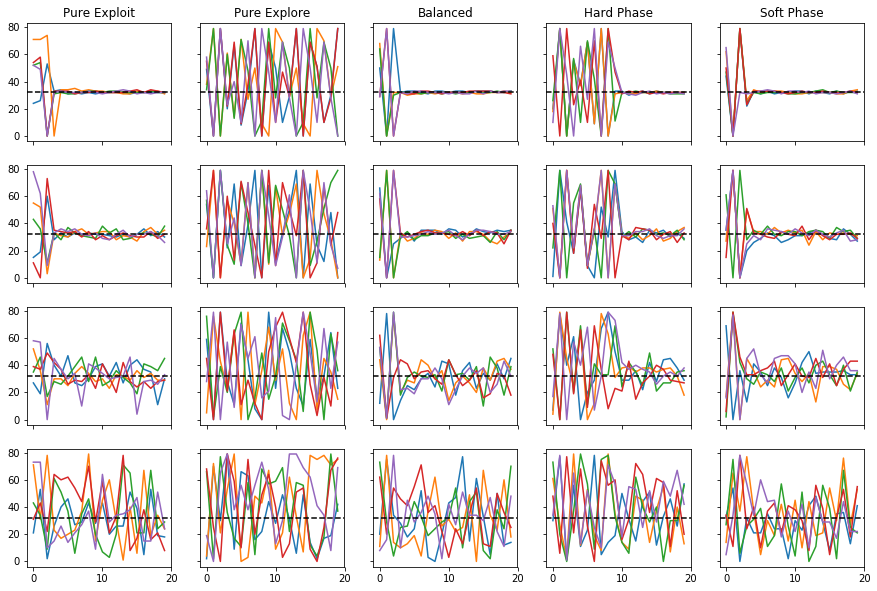

In [14]:
fig, axes = plt.subplots(len(temp_params), len(x_midpoint_params), sharex=True, sharey=True, figsize=(15,10))
for j in range(len(temp_params)):
    for i in range(len(x_midpoint_params)):
        actions = data[j][i][:,:,5].argmax(axis=2)
        axes[j][i].plot(actions[:5].T);
        axes[j][i].axhline(y=fmax, ls='--', c='black');
        if j == 0:
            axes[j][i].set_title(titles[i])

## Pure Exploit

In [15]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][0], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    exploit_trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:47<00:00, 92.37draws/s] 
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
There were 280 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7087503977612746, but should be close to 0.8. Try to increase the number of tuning steps.
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
exploit_params = get_params(exploit_trace)
exploit_mean = exploit_params.mean()

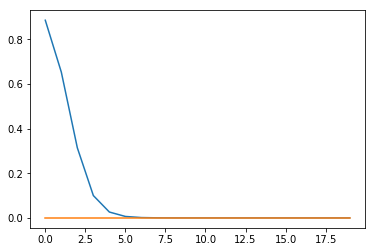

In [17]:
plt.plot(1 - 1. / (1 + exploit_mean['yscale']* np.exp(-exploit_mean['steepness'] * (trials - exploit_mean['x_midpoint']))))
plt.plot(explore[0])

## Pure Explore

In [18]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][1], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    explore_trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:27<00:00, 161.02draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


In [19]:
explore_params = get_params(explore_trace)
explore_mean = explore_params.mean()

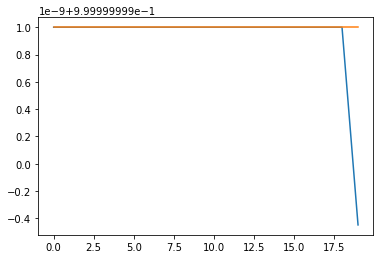

In [20]:
plt.plot(1 - 1. / (1 + explore_mean['yscale']* np.exp(-explore_mean['steepness'] * (trials - explore_mean['x_midpoint']))))
plt.plot(explore[1])

## Balanced

In [21]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][2], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    balanced_trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:58<00:00, 75.32draws/s] 
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
There were 164 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4332397516488604, but should be close to 0.8. Try to increase the number of tuning steps.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6136616055124726, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampli

In [22]:
balanced_params = get_params(balanced_trace)
balanced_mean = balanced_params.mean()

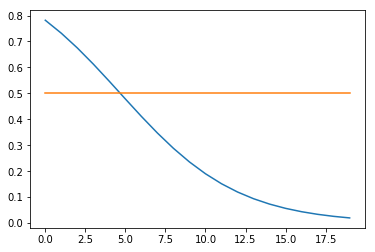

In [23]:
plt.plot(1 - 1. / (1 + balanced_mean['yscale']* np.exp(-balanced_mean['steepness'] * (trials - balanced_mean['x_midpoint']))))
plt.plot(explore[2])

## Hard Phase

In [24]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][3], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    hp_trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 4400/4400 [00:40<00:00, 108.15draws/s]
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [25]:
hp_params = get_params(hp_trace)
hp_mean = hp_params.mean()

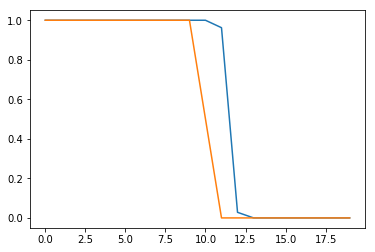

In [26]:
plt.plot(1 - 1. / (1 + hp_mean['yscale']* np.exp(-hp_mean['steepness'] * (trials - hp_mean['x_midpoint']))))
plt.plot(explore[3])

In [27]:
with pm.Model() as model:
    steepness = pm.Gamma('steepness', 1., 1., shape=1)
    x_midpoint = pm.Uniform('x_midpoint', 0, 20, shape=1)
    yscale = pm.Gamma('yscale', 1., 1., shape=1)
    temperature = pm.Gamma('temperature', .1, .1, shape=1)

    obs = pm.Potential('obs', likelihood(data[0][4], phase_ucb_acq, {'steepness': steepness, 
                               'temperature': temperature, 'x_midpoint': x_midpoint,
                               'yscale': yscale}, 1, [1.]))
    sp_trace = pm.sample(600)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [temperature, yscale, x_midpoint, steepness]
Sampling 4 chains: 100%|██████████| 4400/4400 [02:04<00:00, 10.33draws/s] 
There were 413 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.42517773314467144, but should be close to 0.8. Try to increase the number of tuning steps.
There were 463 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2947306763432197, but should be close to 0.8. Try to increase the number of tuning steps.
There were 243 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.686551184488564, but should be close to 0.8. Try to increase the number of tuning steps.
There were 182 divergences after tuning. Inc

In [30]:
sp_params = get_params(sp_trace)
sp_mean = sp_params.mean()

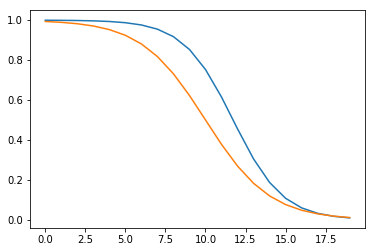

In [31]:
plt.plot(1 - 1. / (1 + sp_mean['yscale']* np.exp(-sp_mean['steepness'] * (trials - sp_mean['x_midpoint']))))
plt.plot(explore[4])